In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as tfms
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 
import torch
from PIL import Image
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import timm
from sklearn.metrics import f1_score, average_precision_score


import warnings
warnings.filterwarnings("ignore")

base = "../input/hpa-single-cell-image-classification/"
# base = "/kaggle/input/hpa-single-small-dataset/"

TRAIN_DF_PATH = base + "train.csv"
TRAIN_IMG_PATH = base + "train"
TEST_IMG_PATH = base + "test"
SAMPLE_SUB = base + "sample_submission.csv"
CELL_LABEL = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles",
5:  "Nuclear bodies",
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus",
8:  "Intermediate filaments",
9:  "Actin filaments", 
10: "Microtubules",
11:  "Mitotic spindle",
12:  "Centrosome",   
13:  "Plasma membrane",
14:  "Mitochondria",   
15:  "Aggresome",
16:  "Cytosol",   
17:  "Vesicles and punctate cytosolic patterns",   
18:  "Negative"
}

train_df = pd.read_csv(TRAIN_DF_PATH)
train_df['label_count'] = train_df['Label'].apply(lambda x: len(x.split("|")))
# train_df.head()

#hyperparameters
CLASS = 19
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
RESIZE = 256
DEVICE = torch.device('cuda') if torch.cuda.is_available() \
         else torch.device('cpu')
PATH = base
TRAIN_DIR = PATH + 'train/'
TEST_DIR = PATH + 'test/'

#imagenet transform
img_tfms = tfms.Compose([
    tfms.ToPILImage(),
    tfms.RandomHorizontalFlip(),
    tfms.RandomVerticalFlip(),
    tfms.RandomRotation(20),
    tfms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    tfms.ToTensor(),
    tfms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

DEVICE

class HPADataset(Dataset):
    def __init__(self, csv_path, ids, labels=None, resize=None, transforms=None):
        self.csv_path = csv_path
        self.ids = ids
        self.labels = labels  # Can be None for test set
        self.resize = resize
        self.transforms = transforms
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        img_path = os.path.join(self.csv_path, img_id + '_green.png')
        image = cv2.imread(img_path)

        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        if self.resize:
            image = cv2.resize(image, (self.resize, self.resize))

        # Ensure image is uint8 (for transforms compatibility)
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)

        if self.transforms:
            image = self.transforms(image)

        if self.labels is not None:  # Training/Validation mode
            label = self.labels[index]
            return image, torch.tensor(label, dtype=torch.float32)
        else:  # Test mode
            return image, img_id

#model
class EfficientNet(nn.Module):
    def __init__(self,output_features, model_name = 'efficientnet_b3', pertrained=True):
        super(EfficientNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pertrained)
        # EfficientNet uses .classifier instead of .head.fc
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(nn.Linear(in_features, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, output_features))
        
    def forward(self, x):
        x = self.model(x)
        return x

class CNNet(nn.Module):
    def __init__(self, input_features, output_features):
        super(CNNet, self).__init__()
        self.model = torchvision.models.resnet34(pretrained=True)
        self.model.fc = nn.Sequential(nn.Linear(input_features, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, output_features))

    def forward(self, x):
        out = self.model(x)
        return out


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # BCE with logits
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probas = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probas, 1 - probas)
        focal_term = self.alpha * (1 - pt) ** self.gamma
        loss = focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss



print("cell run")

cell run


In [ ]:

model = EfficientNet(CLASS)
model = model.to(DEVICE)
loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


train_df = pd.read_csv(PATH + "train.csv")
train_df = train_df.sample(frac=1).reset_index(drop=True)  # Shuffle
from sklearn.preprocessing import MultiLabelBinarizer

# Split string labels into list of ints
train_df['Label'] = train_df['Label'].apply(lambda x: list(map(int, x.split("|"))))

# Fit binarizer
mlb = MultiLabelBinarizer(classes=range(CLASS))  # Ensure consistent order
y_bin = mlb.fit_transform(train_df['Label'])

# Then pass y_bin to your dataset
X_train = train_df['ID'].values
X_ds = HPADataset(TRAIN_DIR, X_train, y_bin, RESIZE, img_tfms)


# X_ds = HPADataset(TRAIN_DIR, X_train, y_train, RESIZE, img_tfms)

# 80-20 split
total_size = len(X_ds)
val_size = int(0.2 * total_size)
train_size = total_size - val_size
train_ds, valid_ds = random_split(X_ds, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE,shuffle=True)

from sklearn.metrics import f1_score, average_precision_score, multilabel_confusion_matrix
import seaborn as sns

def evaluate_model(model, valid_dl, threshold=0.5, device=DEVICE):
    model.eval()
    all_preds, all_trues = [], []
    images_sample, preds_sample, labels_sample = [], [], []

    with torch.no_grad():
        for img, lbl in valid_dl:
            img = img.to(device)
            lbl = lbl.to(device)
            out = torch.sigmoid(model(img.float()))

            all_preds.append(out.cpu().numpy())
            all_trues.append(lbl.cpu().numpy())

            if len(images_sample) < 8:  # Save samples for plotting
                images_sample.extend(img.cpu().numpy())
                preds_sample.extend(out.cpu().numpy())
                labels_sample.extend(lbl.cpu().numpy())

    preds = np.concatenate(all_preds)
    trues = np.concatenate(all_trues)

    preds_bin = (preds > threshold).astype(int)

    f1 = f1_score(trues, preds_bin, average='macro')
    map_score = average_precision_score(trues, preds, average='macro')
    conf_matrix = multilabel_confusion_matrix(trues, preds_bin)

    print(f"Validation F1 Score: {f1:.4f}")
    print(f"Validation mAP: {map_score:.4f}")

print("cell done")

cell done


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 loss:0.0168
Validation F1 Score: 0.0558
Validation mAP: 0.1443
epoch: 1 loss:0.0157
Validation F1 Score: 0.0655
Validation mAP: 0.2268
epoch: 2 loss:0.0144
Validation F1 Score: 0.1303
Validation mAP: 0.3096
epoch: 3 loss:0.0135
Validation F1 Score: 0.2063
Validation mAP: 0.3574
epoch: 4 loss:0.0129
Validation F1 Score: 0.2700
Validation mAP: 0.4104
epoch: 5 loss:0.0123
Validation F1 Score: 0.2851
Validation mAP: 0.4276
epoch: 6 loss:0.0119
Validation F1 Score: 0.3413
Validation mAP: 0.4552
epoch: 7 loss:0.0115
Validation F1 Score: 0.3550
Validation mAP: 0.4634
epoch: 8 loss:0.0112
Validation F1 Score: 0.3526
Validation mAP: 0.4801
epoch: 9 loss:0.0108
Validation F1 Score: 0.3911
Validation mAP: 0.4987
epoch: 10 loss:0.0106
Validation F1 Score: 0.3863
Validation mAP: 0.5196
epoch: 11 loss:0.0103
Validation F1 Score: 0.4201
Validation mAP: 0.5129
epoch: 12 loss:0.0100
Validation F1 Score: 0.4397
Validation mAP: 0.5304
epoch: 13 loss:0.0098
Validation F1 Score: 0.4517
Validation 

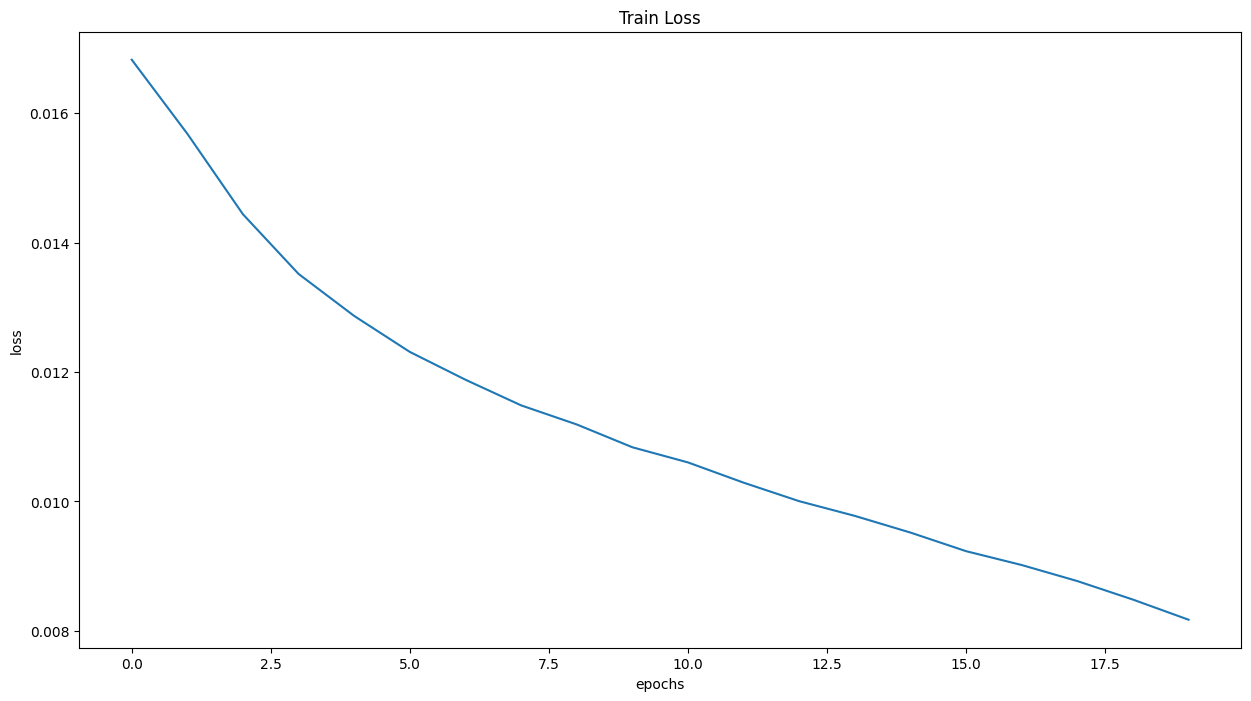

In [3]:
#train loop
loss_hist = []
for epoch in tqdm(range(EPOCHS)):
    losses = []
    model = model.train()
    for batch_idx, (image, label) in enumerate(train_dl):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image.float())
        loss = loss_fn(output, label)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_hist.append(sum(losses)/len(losses))
    
    print(f"epoch: {epoch} loss:{sum(losses)/len(losses):.4f}")

    evaluate_model(model, valid_dl)


plt.figure(figsize=(15, 8))
plt.title('Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss_hist)
plt.show()